In [2]:
# The C2QA pacakge is currently not published to PyPI. 
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cheat to get MS Visual Studio Code Jupyter server to recognize Python venv
module_path = os.path.abspath(os.path.join("../../venv/Lib/site-packages"))
if module_path not in sys.path:
    sys.path.append(module_path)

# Implement Jaynes-Cummings model simulation

## Set constant values

In [3]:
c1 = 1
c2 = 1
d = 1
t = 0.01

## Displacement parameters

In [4]:
d1 = (-1j * d * t) / 2
d2 = (d * t) / 2

## Instantiate the circuit

In [5]:
import c2qa
import qiskit


qmr = c2qa.QumodeRegister(num_qumodes=1, num_qubits_per_qumode=4)
qr = qiskit.QuantumRegister(size=2)
cr = qiskit.ClassicalRegister(size=1)
circuit = c2qa.CVCircuit(qmr, qr, cr)

circuit.rz(-1 * c1 * t, qr[0])
circuit.rz(-1 * c2 * t, qr[1])
circuit.cx(qr[0], qr[1])
circuit.h(qr[0])
circuit.cv_cnd_d(d1, d1, qr[0], qmr[0], inverse=True)
circuit.cx(qr[1], qr[0])
circuit.cv_cnd_d(d1, d1, qr[0], qmr[0])
circuit.cx(qr[1], qr[0])
circuit.cv_cnd_d(d2, d2, qr[0], qmr[0], inverse=True)
circuit.cx(qr[1], qr[0])
circuit.cv_cnd_d(d2, d2, qr[0], qmr[0])
circuit.cx(qr[1], qr[0])
circuit.h(qr[0])
circuit.cx(qr[0], qr[1])

c:\Users\stav405\git\c2qa-qiskit\venv\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
c:\Users\stav405\git\c2qa-qiskit\venv\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


## Simulate the circuit

In [6]:
state, result = c2qa.util.simulate(circuit)

## Animate the circuit

c:\Users\stav405\git\c2qa-qiskit\venv\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
c:\Users\stav405\git\c2qa-qiskit\venv\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
c:\Users\stav405\git\c2qa-qiskit\venv\lib\site-packages\qiskit\extensions\quantum_initializer\squ.py:143: RuntimeWarning: invalid value encountered in arccos
  beta = 2 * np.arccos(np.abs(u00))


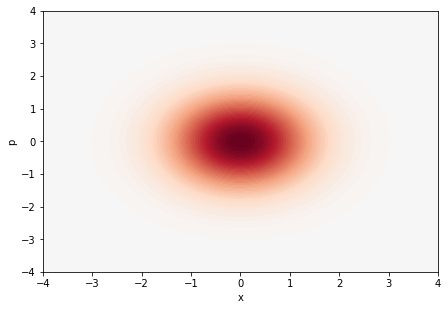

In [6]:
anim = c2qa.util.animate_wigner(
    circuit,
    qubit=qr[0],
    cbit=cr[0],
    axes_min=-4,
    axes_max=4,
    animation_segments=48,
    shots=128
)

In [7]:
c2qa.util.save_animation(anim, "jaynes-cummings.mp4")

In [8]:
from IPython.display import HTML
HTML(anim.to_html5_video())

## Validate state vector with calculated Hamiltonian

In [49]:
import scipy.sparse.linalg
from scipy.sparse import kron

X = scipy.sparse.csr_matrix([[0, 1], [1, 0]])      # Pauli X
Y = scipy.sparse.csr_matrix([[0, -1j], [-1j, 0]])  # Pauli Y
Z = scipy.sparse.csr_matrix([[1, 0], [0, -1]])     # Pauli Z

b = circuit.ops.a
b_dag = circuit.ops.a_dag

# Hamiltonian
#   H = (c1 * a_dag1 * a1) + (c2 * a_dag2 * a2) + d( (a_dag1 * a2 * b) + (a_dag2 * a1 * b_dag) )
#     c1, c2, d -- constants supplied by user
#     a_dag1, a1, a_dag2, a2 -- fermionic creation & annihilation operators
#     b_dag, b -- bosonic creation & annihilation operators


# Jordan-Wigner Transformation
#   H = (-1 * c1 / 2 * Z) - (c2 / 2 * Z) + d * ( ((kron(X, X) + kron(Y, Y)) / 4 * (b + b_dag)) + (1j * (kron(X, Y) - kron(Y, X)) / 4 * (b - b_dag)) )
eye_f = scipy.sparse.csr_matrix([[1, 0], [ 0, 1]])
eye_b = circuit.ops.eye
eye_tensor = kron(eye_f, eye_b)

term1 = kron((-1 * c1 / 2 * Z), eye_tensor)
term2 = kron((c2 / 2 * Z), eye_tensor)

xx = kron(X, X)
yy = kron(Y, Y)
xx_yy = xx + yy
term3 = kron((xx_yy / 4), (b + b_dag))

xy = kron(X, Y)
yx = kron(Y, X)
xy_yx = xx - yy
term4 = kron((1j * (xy_yx / 4)), (b - b_dag))

tmp1 = term1 - term2
tmp2 = d * (term3 + term4)

print(f"tmp1 {tmp1.get_shape()}")
print(f"tmp2 {tmp2.get_shape()}")

H = tmp1 + tmp2


tmp1 (2, 2)
tmp2 (64, 64)


ValueError: inconsistent shapes

### Print Hamiltonian

In [14]:
print(H.toarray())

  (1, 0)	1.0
  (1, 1)	2.0
  (1, 2)	1.4142135623730951
  (2, 1)	2.8284271247461907
  (2, 2)	4.000000000000001
  (2, 3)	3.4641016151377553
  (3, 2)	5.196152422706631
  (3, 3)	5.999999999999999
  (3, 4)	5.999999999999999
  (4, 3)	8.0
  (4, 4)	8.0
  (4, 5)	8.94427190999916
  (5, 4)	11.18033988749895
  (5, 5)	10.000000000000002
  (5, 6)	12.247448713915892
  (6, 5)	14.696938456699066
  (6, 6)	11.999999999999998
  (6, 7)	15.874507866387543
  (7, 6)	18.520259177452136
  (7, 7)	14.000000000000002
  (7, 8)	19.798989873223334
  (8, 7)	22.627416997969526
  (8, 8)	16.000000000000004
  (8, 9)	24.000000000000007
  (9, 8)	27.0
  (9, 9)	18.0
  (9, 10)	28.460498941515414
  (10, 9)	31.6227766016838
  (10, 10)	20.000000000000004
  (10, 11)	33.166247903554
  (11, 10)	36.4828726939094
  (11, 11)	22.0
  (11, 12)	38.1051177665153
  (12, 11)	41.56921938165305
  (12, 12)	23.999999999999996
  (12, 13)	43.26661530556786
  (13, 12)	46.872166581031856
  (13, 13)	25.999999999999996
  (13, 14)	48.64154602806123
  (14

### Print Exponentiation

In [13]:
# h_bar = scipy.constants.hbar
h_bar = 1  # Hamiltonian in units of frequency
H_exp = (-1j * H * t) / h_bar
print(scipy.sparse.linalg.expm(H_exp).toarray())

[[ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
   0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
  nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
  nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
  nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
  nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
  nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj]
 [nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj nan+nanj
  nan+nanj nan+nanj nan+nanj nan

### Print Statevector

In [10]:
print(qiskit.quantum_info.DensityMatrix(state))

DensityMatrix([[ 9.80198673e-01+0.00000000e+00j,
                 9.80198673e-02+9.80198673e-02j,
                -1.52789673e-13+1.38621026e-02j, ...,
                -3.37013909e-15+6.53239234e-15j,
                 2.63110906e-14-2.81955948e-15j,
                 7.87813363e-16-6.92070635e-15j],
               [ 9.80198673e-02-9.80198673e-02j,
                 1.96039735e-02+0.00000000e+00j,
                 1.38621026e-03+1.38621026e-03j, ...,
                 3.16225325e-16+9.90253142e-16j,
                 2.34915312e-15-2.91306501e-15j,
                -6.13289298e-16-7.70851971e-16j],
               [-1.52789673e-13-1.38621026e-02j,
                 1.38621026e-03-1.38621026e-03j,
                 1.96039735e-04+0.00000000e+00j, ...,
                 9.23819783e-17+4.76609641e-17j,
                -3.98745926e-17-3.72095012e-16j,
                -9.78735678e-17-1.11413634e-17j],
               ...,
               [-3.37013909e-15-6.53239234e-15j,
                 3.16225325e-16

### Print Probabilities

In [11]:
print(state.probabilities())

[9.80198673e-01 1.96039735e-02 1.96039735e-04 1.30693156e-06
 6.53465783e-09 2.61386315e-11 8.71286213e-14 2.48988068e-16
 6.32190514e-19 1.48326660e-21 3.69295988e-24 3.31784080e-27
 4.81542565e-29 1.38136003e-29 1.52966269e-27 1.78881428e-29
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.49372634e-26 7.72265867e-26 5.97217684e-26 2.79817731e-26
 2.43420373e-27 1.29587590e-28 4.52282947e-27 2.50669137e-25
 2.45644219e-24 9.36678592e-26 1.25634078e-26 2.31780937e-28
 9.60389676e-30 5.51214652e-29 7.14368857e-28 4.94969311e-29]
